In [ ]:
import os
import cv2

# Function to load images and labels from a directory
def load_images(folder, label, img_size=(128,128)):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, img_size)
            images.append(img)
            labels.append(label)
    return images, labels

# Load forged and original images
forged_images, forged_labels = load_images('dataset/forged', 1)
original_images, original_labels = load_images('dataset/original', 0)

# Combine both
images = forged_images + original_images
labels = forged_labels + original_labels


In [ ]:
import numpy as np

# Feature extraction function
def extract_features(img):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # 1. Edge feature
    edges = cv2.Canny(gray, 100, 200)
    edge_count = np.sum(edges > 0)
    
    # 2. Histogram feature (16 bins)
    hist = cv2.calcHist([gray], [0], None, [16], [0,256])
    hist = hist.flatten() / hist.sum()  # normalize
    
    # Combine all features into a single vector
    features = np.hstack([edge_count, hist])
    return features


In [ ]:
# Extract features for all images
X = np.array([extract_features(img) for img in images])
y = np.array(labels)

print("Feature matrix shape:", X.shape)
print("Labels shape:", y.shape)


Feature matrix shape: (363, 17)
Labels shape: (363,)


In [6]:
from sklearn.model_selection import train_test_split

# Split features and labels
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training set size:", X_train.shape[0])
print("Testing set size:", X_test.shape[0])


Training set size: 290
Testing set size: 73


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Create Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train
clf.fit(X_train, y_train)

print("Model training complete!")


Model training complete!


In [ ]:
from sklearn.metrics import accuracy_score, classification_report
import joblib

# Predict on test set
y_pred = clf.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

# Detailed report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Save the model
joblib.dump(clf, "forgery_model.pkl")
print("Model saved as forgery_model.pkl")


Test Accuracy: 0.726027397260274

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.67      0.69        33
           1       0.74      0.78      0.76        40

    accuracy                           0.73        73
   macro avg       0.72      0.72      0.72        73
weighted avg       0.73      0.73      0.73        73

Model saved as forgery_model.pkl


In [ ]:
# Predict Test Image

def predict_image(img_path):
    # Load image
    img = cv2.imread(img_path)
    if img is None:
        print("Image not found:", img_path)
        return
    
    # Resize to match training size
    img = cv2.resize(img, (128,128))
    
    # Extract features
    feat = extract_features(img)
    
    # Predict
    pred = clf.predict([feat])[0]
    label = "Forged" if pred == 1 else "Original"
    
    print(f"Prediction for '{img_path}': {label}")
    
    # Show image
    cv2.imshow("Test Image", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Test Image usage
predict_image('dataset/test_image.png')


Prediction for 'dataset/test_image.png': Forged


Confusion Matrix:
 [[22 11]
 [ 9 31]]


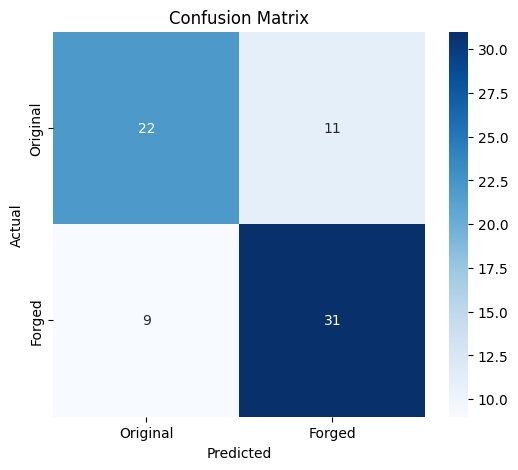

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Build confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Create a heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Original','Forged'], yticklabels=['Original','Forged'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()
